# Hand-written digit Recognition

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## load MNIST images

## define the neural network

In [4]:
import matplotlib.pyplot as plt
import random
import numpy as np
import mnist_loader

class Network(object):
    def __init__(self, layers):
        """ 
        layers is a list. length of layers is the number of layers. each entry in the 
        list denotes the number of neurons in each layer
        layers = [num neurons in layer 0, num neurons in layer 1, num neurons in layer 2, ...]        
        """
        self.layers = layers
        self.numLayers = len(layers)
        
        # initialize weights = [[from all input to neuron 0], [from all input to neuron 1], ...]
        self.weights = [np.random.randn(y, x) for x, y in zip(self.layers[:-1], self.layers[1:])]
        # initialize biases = [none, vector of all layer 1 neurons, vector of all layer 2 neurons, ...]
        # every layer has one bias
        self.biases  = [np.random.randn(y, 1) for y in self.layers[1:]]
        # Constants for speeding up 
        self.weightGradZeroed = [np.zeros(w.shape) for w in self.weights]
        self.biasGradZeroed = [np.zeros(b.shape) for b in self.biases]
   
    # compute gradient of Quadratic Cost function w.r.t activation of output layer
    # partial derivative C / partial derivative aL = aL - y
    def costDerivative(self, aL, y):
        return (aL - y)
    
    # Sigmoid Activation Function
    def sigmoid(self, z):
        return (1.0/(1.0+np.exp(-z)))
    
    # Derivative of the sigmoid function"""
    def sigmoid_prime(self, z):
        return self.sigmoid(z)*(1-self.sigmoid(z))

    def ff(self, a):
        # Return the output of the network if ``a`` is input
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a)+b)
        return a
    
    def feedForward(self, x):
        """
        1. compute weighted input z for every neuron from layer 2 to L
        2. compute activation a = sigmoid(z) for every neuron from layer 2 to L
        """
        activation = x
        activations = [x]
        # zs is a list of all z in all layers
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)

        return activations, zs
            
    """
    1. Call feedForward to compute all activations and weighted input in every layer
    2. Compute gradients of weights and biases of every layer
    """    
    def backprop(self, x, y):
        # call feed forward to compute z and a of every layer. 
        # input x is the activation of layer 0
        activations, zs = self.feedForward(x)
        
        bpBiasGrad = [np.zeros(b.shape) for b in self.biases]
        bpWeightGrad = [np.zeros(w.shape) for w in self.weights]
        
        # Last layer L: error (delta) and weights
        delta = self.costDerivative(activations[-1], y) * self.sigmoid_prime(zs[-1])
        weights = np.dot(delta, activations[-2].transpose())
        bpBiasGrad[-1] = delta
        bpWeightGrad[-1] = weights
        
        # back propagate error, starting from the penultimate layer
        for l in range(1, self.numLayers-1):
            sp = self.sigmoid_prime(zs[-1-l])
            delta = np.dot(self.weights[-l].transpose(), delta) * sp
            weights = np.dot(delta, activations[-2-l].transpose())
            bpBiasGrad[-1-l] = delta
            bpWeightGrad[-1-l] = weights
            
        return bpBiasGrad, bpWeightGrad, activations

  
    def updateMiniBatch(self, mini_batch, lr):
        """
        Iterate through every sample in a mini-batch. mini_batch is a tuple of (x, y)
            1. Call backprop
            2. Accumulate gradients from sample to sample

        At the end of one mini-batch
            1. Updated weights = previous weights - scaled learning rate * accumulated weights
            2. Update biases = previous bias - scaled learning rate * accumulated biases
        """
        
        # initialize bias and weight accumulators
        
        #weightGradAccum = [np.zeros(w.shape) for w in self.weights]
        #biasGradAccum = [np.zeros(b.shape) for b in self.biases]

        # zero out the accumulators
        weightGradAccum = self.weightGradZeroed
        biasGradAccum   = self.biasGradZeroed
        
        # iterate every sample in the mini-batch
        for x, y in mini_batch:
            # backprop returns computed gradients of biases and weights of one sample
            biasGrad, weightGrad, activations = self.backprop(x, y)
            # biasAccum = [biasAccum + biasGrad] ??
            biasGradAccum   = [ba+bg for ba, bg in zip(biasGradAccum, biasGrad)]
            weightGradAccum = [wa+wg for wa, wg in zip(weightGradAccum, weightGrad)]
        
        # compute effective learning rate 
        effectiveLr = lr/len(mini_batch)
        
        # update biases and weights
        self.biases = [b - bg * effectiveLr for b, bg in zip(self.biases, biasGradAccum)]
        self.weights = [w - wg * effectiveLr for w, wg in zip(self.weights, weightGradAccum)]
        
        self.dispActivations(activations)
        
    def dispActivations(self, activations):
        """ 
        display activations of the last two layers at the end of one mini-batch 
        """
        firstLayer = activations[0]
        digit = np.reshape(firstLayer, (28,28))
        plt.imshow(digit)

        secondLayer = activations[1]
        digit = np.reshape(secondLayer, (4,4))
        plt.imshow(digit)
        


    def train(self, training_data, epochs, mini_batch_size, lr, test_data=None):
        """
        run N epochs
          1. shuffle training data
          2. create a list of mini-batches from training data
          3. take each mini-batch and call updateMiniBatch 
          4. update weights and biases after each mini-batch
          5. If there is test data, call evaluate with test data and print result
             else print Epoch number complete
        """
        # cast training_data from zip object to list of zipped pairs
        training_data_list = list(training_data)
        n = len(training_data_list)
        
        test_data_list = list(test_data)
        n_test = len(test_data_list)
        
        for iEpoch in range (epochs):
            np.random.shuffle(training_data_list)
            mini_batches = [training_data_list[iSample:iSample+mini_batch_size] for iSample in range(0, n, mini_batch_size)]
            
            # run one mini-batch at a time until all mini-batches are processed
            for mini_batch in mini_batches:
                self.updateMiniBatch(mini_batch, lr)
                
            print('========= finished training ======')
            if test_data:
                test_results = self.evaluate(test_data_list)
                print ("Epoch {0}: {1} / {2}".format(
                    iEpoch, test_results, n_test))
            else:
                print ('Epoch {0} complete'.format(iEpoch))
                
    def evaluate(self, test_data):
        """Return the number of test inputs where the neural
        network outputs the correct result. Neural
        network's output is the index of the neuron in the final layer 
        that has the highest activation."""
        
        test_results = [(np.argmax(self.ff(x)),y)
                        for (x, y) in test_data]

        return sum(int(x == y) for (x, y) in test_results)

In [5]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

========= finished training ======
Epoch 0: 7495 / 10000
========= finished training ======
Epoch 1: 8432 / 10000
========= finished training ======
Epoch 2: 8724 / 10000
========= finished training ======
Epoch 3: 8855 / 10000
========= finished training ======
Epoch 4: 8904 / 10000


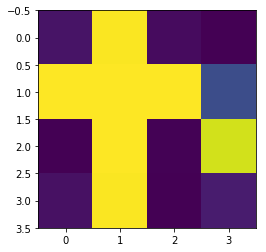

In [6]:
net = Network([784, 16, 10])
net.train(training_data, 5, 64, lr=3.0, test_data=test_data)

In [34]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
sample0 = list(training_data)
data = sample0[0][0]
len(sample0), len(sample0[0]), len(data)

(50000, 2, 784)

In [4]:
temp = [print ('{0} {1}'.format(x.shape, y)) for (x, y) in test_data]

(784, 1) 7
(784, 1) 2
(784, 1) 1
(784, 1) 0
(784, 1) 4
(784, 1) 1
(784, 1) 4
(784, 1) 9
(784, 1) 5
(784, 1) 9
(784, 1) 0
(784, 1) 6
(784, 1) 9
(784, 1) 0
(784, 1) 1
(784, 1) 5
(784, 1) 9
(784, 1) 7
(784, 1) 3
(784, 1) 4
(784, 1) 9
(784, 1) 6
(784, 1) 6
(784, 1) 5
(784, 1) 4
(784, 1) 0
(784, 1) 7
(784, 1) 4
(784, 1) 0
(784, 1) 1
(784, 1) 3
(784, 1) 1
(784, 1) 3
(784, 1) 4
(784, 1) 7
(784, 1) 2
(784, 1) 7
(784, 1) 1
(784, 1) 2
(784, 1) 1
(784, 1) 1
(784, 1) 7
(784, 1) 4
(784, 1) 2
(784, 1) 3
(784, 1) 5
(784, 1) 1
(784, 1) 2
(784, 1) 4
(784, 1) 4
(784, 1) 6
(784, 1) 3
(784, 1) 5
(784, 1) 5
(784, 1) 6
(784, 1) 0
(784, 1) 4
(784, 1) 1
(784, 1) 9
(784, 1) 5
(784, 1) 7
(784, 1) 8
(784, 1) 9
(784, 1) 3
(784, 1) 7
(784, 1) 4
(784, 1) 6
(784, 1) 4
(784, 1) 3
(784, 1) 0
(784, 1) 7
(784, 1) 0
(784, 1) 2
(784, 1) 9
(784, 1) 1
(784, 1) 7
(784, 1) 3
(784, 1) 2
(784, 1) 9
(784, 1) 7
(784, 1) 7
(784, 1) 6
(784, 1) 2
(784, 1) 7
(784, 1) 8
(784, 1) 4
(784, 1) 7
(784, 1) 3
(784, 1) 6
(784, 1) 1
(784, 1) 3

(784, 1) 3
(784, 1) 8
(784, 1) 5
(784, 1) 3
(784, 1) 5
(784, 1) 8
(784, 1) 6
(784, 1) 5
(784, 1) 7
(784, 1) 6
(784, 1) 3
(784, 1) 3
(784, 1) 9
(784, 1) 6
(784, 1) 1
(784, 1) 1
(784, 1) 2
(784, 1) 9
(784, 1) 0
(784, 1) 4
(784, 1) 3
(784, 1) 3
(784, 1) 6
(784, 1) 9
(784, 1) 5
(784, 1) 7
(784, 1) 3
(784, 1) 7
(784, 1) 7
(784, 1) 7
(784, 1) 8
(784, 1) 7
(784, 1) 9
(784, 1) 8
(784, 1) 3
(784, 1) 0
(784, 1) 7
(784, 1) 2
(784, 1) 7
(784, 1) 9
(784, 1) 4
(784, 1) 5
(784, 1) 4
(784, 1) 9
(784, 1) 3
(784, 1) 2
(784, 1) 1
(784, 1) 4
(784, 1) 0
(784, 1) 2
(784, 1) 3
(784, 1) 7
(784, 1) 5
(784, 1) 7
(784, 1) 8
(784, 1) 8
(784, 1) 5
(784, 1) 0
(784, 1) 1
(784, 1) 1
(784, 1) 4
(784, 1) 8
(784, 1) 3
(784, 1) 9
(784, 1) 0
(784, 1) 0
(784, 1) 0
(784, 1) 6
(784, 1) 6
(784, 1) 2
(784, 1) 3
(784, 1) 7
(784, 1) 8
(784, 1) 4
(784, 1) 7
(784, 1) 7
(784, 1) 9
(784, 1) 2
(784, 1) 4
(784, 1) 1
(784, 1) 4
(784, 1) 5
(784, 1) 2
(784, 1) 4
(784, 1) 9
(784, 1) 9
(784, 1) 1
(784, 1) 8
(784, 1) 4
(784, 1) 0
(784, 1) 9

(784, 1) 6
(784, 1) 6
(784, 1) 8
(784, 1) 6
(784, 1) 9
(784, 1) 1
(784, 1) 7
(784, 1) 2
(784, 1) 5
(784, 1) 9
(784, 1) 9
(784, 1) 0
(784, 1) 7
(784, 1) 2
(784, 1) 7
(784, 1) 6
(784, 1) 7
(784, 1) 0
(784, 1) 6
(784, 1) 5
(784, 1) 2
(784, 1) 4
(784, 1) 7
(784, 1) 2
(784, 1) 0
(784, 1) 9
(784, 1) 9
(784, 1) 2
(784, 1) 2
(784, 1) 9
(784, 1) 4
(784, 1) 4
(784, 1) 2
(784, 1) 3
(784, 1) 3
(784, 1) 2
(784, 1) 1
(784, 1) 7
(784, 1) 0
(784, 1) 7
(784, 1) 6
(784, 1) 4
(784, 1) 1
(784, 1) 3
(784, 1) 8
(784, 1) 7
(784, 1) 4
(784, 1) 5
(784, 1) 9
(784, 1) 2
(784, 1) 5
(784, 1) 1
(784, 1) 8
(784, 1) 7
(784, 1) 3
(784, 1) 7
(784, 1) 1
(784, 1) 5
(784, 1) 5
(784, 1) 0
(784, 1) 9
(784, 1) 1
(784, 1) 4
(784, 1) 0
(784, 1) 6
(784, 1) 3
(784, 1) 3
(784, 1) 6
(784, 1) 0
(784, 1) 4
(784, 1) 9
(784, 1) 7
(784, 1) 5
(784, 1) 1
(784, 1) 6
(784, 1) 8
(784, 1) 9
(784, 1) 5
(784, 1) 5
(784, 1) 7
(784, 1) 9
(784, 1) 3
(784, 1) 8
(784, 1) 3
(784, 1) 8
(784, 1) 1
(784, 1) 5
(784, 1) 3
(784, 1) 5
(784, 1) 0
(784, 1) 5

(784, 1) 5
(784, 1) 3
(784, 1) 5
(784, 1) 1
(784, 1) 9
(784, 1) 8
(784, 1) 2
(784, 1) 3
(784, 1) 3
(784, 1) 9
(784, 1) 9
(784, 1) 0
(784, 1) 1
(784, 1) 0
(784, 1) 2
(784, 1) 9
(784, 1) 3
(784, 1) 9
(784, 1) 3
(784, 1) 3
(784, 1) 6
(784, 1) 2
(784, 1) 4
(784, 1) 9
(784, 1) 8
(784, 1) 3
(784, 1) 7
(784, 1) 4
(784, 1) 0
(784, 1) 4
(784, 1) 7
(784, 1) 8
(784, 1) 4
(784, 1) 9
(784, 1) 8
(784, 1) 9
(784, 1) 9
(784, 1) 7
(784, 1) 5
(784, 1) 9
(784, 1) 2
(784, 1) 8
(784, 1) 2
(784, 1) 2
(784, 1) 0
(784, 1) 2
(784, 1) 2
(784, 1) 3
(784, 1) 8
(784, 1) 4
(784, 1) 6
(784, 1) 8
(784, 1) 6
(784, 1) 8
(784, 1) 2
(784, 1) 4
(784, 1) 6
(784, 1) 7
(784, 1) 9
(784, 1) 3
(784, 1) 3
(784, 1) 9
(784, 1) 4
(784, 1) 3
(784, 1) 1
(784, 1) 4
(784, 1) 4
(784, 1) 7
(784, 1) 0
(784, 1) 5
(784, 1) 9
(784, 1) 6
(784, 1) 0
(784, 1) 4
(784, 1) 4
(784, 1) 4
(784, 1) 4
(784, 1) 6
(784, 1) 1
(784, 1) 2
(784, 1) 3
(784, 1) 3
(784, 1) 6
(784, 1) 4
(784, 1) 5
(784, 1) 9
(784, 1) 6
(784, 1) 8
(784, 1) 5
(784, 1) 6
(784, 1) 5

(784, 1) 7
(784, 1) 4
(784, 1) 3
(784, 1) 0
(784, 1) 7
(784, 1) 5
(784, 1) 0
(784, 1) 7
(784, 1) 4
(784, 1) 2
(784, 1) 0
(784, 1) 8
(784, 1) 9
(784, 1) 9
(784, 1) 4
(784, 1) 2
(784, 1) 4
(784, 1) 6
(784, 1) 7
(784, 1) 8
(784, 1) 7
(784, 1) 6
(784, 1) 9
(784, 1) 4
(784, 1) 1
(784, 1) 3
(784, 1) 7
(784, 1) 3
(784, 1) 0
(784, 1) 8
(784, 1) 8
(784, 1) 7
(784, 1) 6
(784, 1) 9
(784, 1) 3
(784, 1) 9
(784, 1) 2
(784, 1) 2
(784, 1) 9
(784, 1) 2
(784, 1) 1
(784, 1) 8
(784, 1) 3
(784, 1) 2
(784, 1) 9
(784, 1) 6
(784, 1) 8
(784, 1) 4
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 8
(784, 1) 4
(784, 1) 5
(784, 1) 2
(784, 1) 7
(784, 1) 8
(784, 1) 1
(784, 1) 1
(784, 1) 3
(784, 1) 0
(784, 1) 3
(784, 1) 5
(784, 1) 7
(784, 1) 0
(784, 1) 3
(784, 1) 1
(784, 1) 9
(784, 1) 3
(784, 1) 6
(784, 1) 3
(784, 1) 1
(784, 1) 7
(784, 1) 7
(784, 1) 3
(784, 1) 0
(784, 1) 8
(784, 1) 4
(784, 1) 8
(784, 1) 2
(784, 1) 6
(784, 1) 5
(784, 1) 2
(784, 1) 9
(784, 1) 7
(784, 1) 3
(784, 1) 9
(784, 1) 0
(784, 1) 9
(784, 1) 9
(784, 1) 6

(784, 1) 6
(784, 1) 3
(784, 1) 6
(784, 1) 0
(784, 1) 7
(784, 1) 3
(784, 1) 5
(784, 1) 4
(784, 1) 2
(784, 1) 4
(784, 1) 1
(784, 1) 8
(784, 1) 3
(784, 1) 5
(784, 1) 6
(784, 1) 7
(784, 1) 0
(784, 1) 6
(784, 1) 7
(784, 1) 1
(784, 1) 2
(784, 1) 5
(784, 1) 8
(784, 1) 1
(784, 1) 9
(784, 1) 3
(784, 1) 8
(784, 1) 2
(784, 1) 8
(784, 1) 7
(784, 1) 6
(784, 1) 7
(784, 1) 1
(784, 1) 4
(784, 1) 6
(784, 1) 2
(784, 1) 9
(784, 1) 3
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 3
(784, 1) 4
(784, 1) 5
(784, 1) 6
(784, 1) 7
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 3
(784, 1) 4
(784, 1) 5
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 8
(784, 1) 9
(784, 1) 1
(784, 1) 4
(784, 1) 0
(784, 1) 9
(784, 1) 5
(784, 1) 0
(784, 1) 8
(784, 1) 0
(784, 1) 7
(784, 1) 7
(784, 1) 1
(784, 1) 1
(784, 1) 2
(784, 1) 9
(784, 1) 3
(784, 1) 6
(784, 1) 7
(784, 1) 2
(784, 1) 3
(784, 1) 8
(784, 1) 1
(784, 1) 2
(784, 1) 9
(784, 1) 8
(784, 1) 8
(784, 1) 7
(784, 1) 1
(784, 1) 7
(784, 1) 1
(784, 1) 1
(784, 1) 0
(784, 1) 3
(784, 1) 4
(784, 1) 2

(784, 1) 2
(784, 1) 8
(784, 1) 1
(784, 1) 2
(784, 1) 0
(784, 1) 7
(784, 1) 1
(784, 1) 0
(784, 1) 4
(784, 1) 4
(784, 1) 5
(784, 1) 8
(784, 1) 0
(784, 1) 6
(784, 1) 2
(784, 1) 3
(784, 1) 1
(784, 1) 5
(784, 1) 1
(784, 1) 8
(784, 1) 5
(784, 1) 9
(784, 1) 4
(784, 1) 0
(784, 1) 7
(784, 1) 5
(784, 1) 8
(784, 1) 8
(784, 1) 3
(784, 1) 8
(784, 1) 9
(784, 1) 2
(784, 1) 6
(784, 1) 2
(784, 1) 5
(784, 1) 3
(784, 1) 1
(784, 1) 7
(784, 1) 3
(784, 1) 9
(784, 1) 1
(784, 1) 9
(784, 1) 9
(784, 1) 6
(784, 1) 0
(784, 1) 3
(784, 1) 9
(784, 1) 2
(784, 1) 8
(784, 1) 1
(784, 1) 4
(784, 1) 3
(784, 1) 5
(784, 1) 2
(784, 1) 9
(784, 1) 2
(784, 1) 5
(784, 1) 8
(784, 1) 9
(784, 1) 5
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 4
(784, 1) 5
(784, 1) 6
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 3
(784, 1) 4
(784, 1) 5
(784, 1) 6
(784, 1) 7
(784, 1) 1
(784, 1) 2
(784, 1) 3
(784, 1) 4
(784, 1) 5
(784, 1) 1
(784, 1) 0
(784, 1) 4
(784, 1) 5
(784, 1) 6
(784, 1) 6
(784, 1) 3
(784, 1) 4
(784, 1) 4
(784, 1) 2
(784, 1) 8
(784, 1) 1

(784, 1) 6
(784, 1) 7
(784, 1) 1
(784, 1) 2
(784, 1) 3
(784, 1) 9
(784, 1) 2
(784, 1) 4
(784, 1) 5
(784, 1) 5
(784, 1) 3
(784, 1) 7
(784, 1) 5
(784, 1) 3
(784, 1) 1
(784, 1) 8
(784, 1) 2
(784, 1) 2
(784, 1) 3
(784, 1) 0
(784, 1) 2
(784, 1) 9
(784, 1) 4
(784, 1) 9
(784, 1) 7
(784, 1) 0
(784, 1) 2
(784, 1) 7
(784, 1) 4
(784, 1) 9
(784, 1) 9
(784, 1) 2
(784, 1) 5
(784, 1) 9
(784, 1) 8
(784, 1) 3
(784, 1) 8
(784, 1) 6
(784, 1) 7
(784, 1) 0
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 3
(784, 1) 4
(784, 1) 5
(784, 1) 6
(784, 1) 7
(784, 1) 8
(784, 1) 9
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 3
(784, 1) 4
(784, 1) 5
(784, 1) 6
(784, 1) 7
(784, 1) 8
(784, 1) 9
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 3
(784, 1) 4
(784, 1) 5
(784, 1) 6
(784, 1) 7
(784, 1) 8
(784, 1) 9
(784, 1) 0
(784, 1) 0
(784, 1) 7
(784, 1) 2
(784, 1) 6
(784, 1) 5
(784, 1) 5
(784, 1) 3
(784, 1) 7
(784, 1) 8
(784, 1) 6
(784, 1) 6
(784, 1) 6
(784, 1) 6
(784, 1) 4
(784, 1) 3
(784, 1) 8
(784, 1) 8
(784, 1) 3
(784, 1) 0
(784, 1) 1

(784, 1) 7
(784, 1) 8
(784, 1) 9
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 3
(784, 1) 4
(784, 1) 5
(784, 1) 6
(784, 1) 7
(784, 1) 8
(784, 1) 9
(784, 1) 6
(784, 1) 9
(784, 1) 7
(784, 1) 0
(784, 1) 2
(784, 1) 3
(784, 1) 4
(784, 1) 3
(784, 1) 8
(784, 1) 5
(784, 1) 1
(784, 1) 3
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 1
(784, 1) 3
(784, 1) 2
(784, 1) 0
(784, 1) 7
(784, 1) 2
(784, 1) 6
(784, 1) 4
(784, 1) 0
(784, 1) 5
(784, 1) 9
(784, 1) 9
(784, 1) 8
(784, 1) 9
(784, 1) 5
(784, 1) 3
(784, 1) 1
(784, 1) 7
(784, 1) 4
(784, 1) 7
(784, 1) 0
(784, 1) 0
(784, 1) 6
(784, 1) 6
(784, 1) 6
(784, 1) 3
(784, 1) 7
(784, 1) 4
(784, 1) 2
(784, 1) 8
(784, 1) 9
(784, 1) 8
(784, 1) 7
(784, 1) 1
(784, 1) 4
(784, 1) 0
(784, 1) 4
(784, 1) 8
(784, 1) 5
(784, 1) 2
(784, 1) 3
(784, 1) 9
(784, 1) 0
(784, 1) 1
(784, 1) 9
(784, 1) 1
(784, 1) 5
(784, 1) 1
(784, 1) 7
(784, 1) 6
(784, 1) 1
(784, 1) 2
(784, 1) 1
(784, 1) 6
(784, 1) 8
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 3
(784, 1) 4
(784, 1) 5
(784, 1) 6
(784, 1) 7

(784, 1) 5
(784, 1) 9
(784, 1) 9
(784, 1) 3
(784, 1) 7
(784, 1) 2
(784, 1) 4
(784, 1) 9
(784, 1) 4
(784, 1) 3
(784, 1) 6
(784, 1) 2
(784, 1) 2
(784, 1) 5
(784, 1) 3
(784, 1) 2
(784, 1) 5
(784, 1) 5
(784, 1) 9
(784, 1) 4
(784, 1) 1
(784, 1) 7
(784, 1) 2
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 3
(784, 1) 4
(784, 1) 5
(784, 1) 6
(784, 1) 7
(784, 1) 8
(784, 1) 9
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 3
(784, 1) 4
(784, 1) 5
(784, 1) 6
(784, 1) 7
(784, 1) 8
(784, 1) 9
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 3
(784, 1) 4
(784, 1) 5
(784, 1) 6
(784, 1) 7
(784, 1) 8
(784, 1) 9
(784, 1) 1
(784, 1) 0
(784, 1) 1
(784, 1) 2
(784, 1) 7
(784, 1) 5
(784, 1) 3
(784, 1) 4
(784, 1) 4
(784, 1) 0
(784, 1) 0
(784, 1) 6
(784, 1) 9
(784, 1) 6
(784, 1) 6
(784, 1) 5
(784, 1) 7
(784, 1) 2
(784, 1) 3
(784, 1) 4
(784, 1) 4
(784, 1) 9
(784, 1) 1
(784, 1) 4
(784, 1) 0
(784, 1) 7
(784, 1) 9
(784, 1) 5
(784, 1) 7
(784, 1) 2
(784, 1) 3
(784, 1) 1
(784, 1) 4
(784, 1) 4
(784, 1) 0
(784, 1) 9
(784, 1) 9
(784, 1) 6

In [ ]:
digit = np.reshape(data, (28,28))
plt.imshow(digit)

In [37]:
x = [1, 2, 3]
y = [4, 5, 6]
t = zip (x, y)
s = list(t)

In [40]:
u = [[a, b] for a, b in s]
w = [(b, a) for a, b in s]
print ('s {0} u {1} w {2}'.format(s,u, w))

s [(1, 4), (2, 5), (3, 6)] u [[1, 4], [2, 5], [3, 6]] w [(4, 1), (5, 2), (6, 3)]
